In [1]:
from fastai.vision.all import *
from timm import create_model
from fastai.vision.learner import _update_first_layer

In [2]:
df = pd.read_csv('data/train_ready.csv')
img_path = Path('data/train_features/')
mask_path = Path('data/train_labels/')

In [3]:
df.head(1)

,chip_id,location,datetime,cloudpath,is_valid,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,False,data/train_features/adwp/B02.tif,data/train_features/adwp/B03.tif,data/train_features/adwp/B04.tif,data/train_features/adwp/B08.tif,data/train_labels/adwp.tif


In [4]:
IMG_SIZE = 300
BATCH_SIZE = 2

In [5]:
def get_4chan(fold):
    ims = get_image_files(fold)
    arrs = ims.map(Image.open).map(np.array)
    stack = (np.stack(arrs, axis = -1) / 16000 * 255).astype(np.uint8)
    assert(stack.shape[-1] == 4)
    
    return PILImage.create(stack)

In [6]:
FourChanImageBlock = TransformBlock(type_tfms = get_4chan, batch_tfms = IntToFloatTensor)

In [7]:
db = DataBlock(
    blocks = (FourChanImageBlock, MaskBlock),
    get_x = ColReader('chip_id', pref = img_path),
    get_y = ColReader('label_path'),
    splitter = ColSplitter(),
    item_tfms = Resize(IMG_SIZE),
    #batch_tfms = setup_aug_tfms([#Rotate(), 
    #                             RandomResizedCropGPU(IMG_SIZE, min_scale = 0.3), 
    #                             #Brightness(0.3), 
    #                             #Contrast(0.3), 
    #                             #Hue(), 
    #                             #Saturation(0.3)
    #                            ])
)

In [8]:
dls = db.dataloaders(df, bs = BATCH_SIZE)

/home/karrrrrrrr/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630815121/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


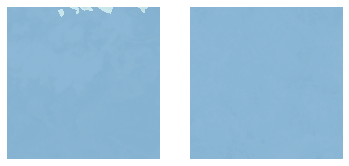

In [9]:
dls.show_batch()

---

In [10]:
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): 
        return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): 
        return cut(model)
    else: 
        raise NamedError("cut must be either integer or function")

In [12]:
body = create_timm_body('efficientnet_b3a', pretrained = True, n_in = 4)
n_out = 2
img_size = dls.one_batch()[0].shape[-2:]

model = models.unet.DynamicUnet(body, n_out, img_size, self_attention = True)
 
learn = Learner(
    dls,
    model,
    metrics = [Dice, JaccardCoeff],
    splitter = default_split
)

learn.freeze()

---

In [16]:
learn.summary()

DynamicUnet (Input shape: 2 x 4 x 300 x 300)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 40 x 150 x 150  
Conv2d                                    1440       True      
BatchNorm2d                               80         True      
SiLU                                                           
Conv2d                                    360        True      
BatchNorm2d                               80         True      
SiLU                                                           
____________________________________________________________________________
                     2 x 10 x 1 x 1      
Conv2d                                    410        True      
SiLU                                                           
____________________________________________________________________________
                     2 x 40 x 1 x 1      
Conv2d                                    440        True      
Sigmoid                            

In [17]:
learn.freeze()

In [18]:
learn.summary()

DynamicUnet (Input shape: 2 x 4 x 300 x 300)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 40 x 150 x 150  
Conv2d                                    1440       False     
BatchNorm2d                               80         True      
SiLU                                                           
Conv2d                                    360        False     
BatchNorm2d                               80         True      
SiLU                                                           
____________________________________________________________________________
                     2 x 10 x 1 x 1      
Conv2d                                    410        False     
SiLU                                                           
____________________________________________________________________________
                     2 x 40 x 1 x 1      
Conv2d                                    440        False     
Sigmoid                            

SuggestedLRs(valley=1.737800812406931e-05)

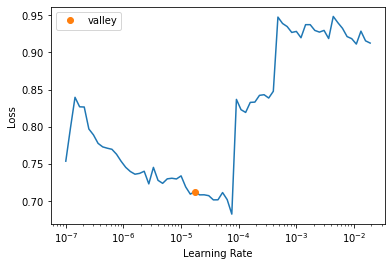

In [13]:
learn.lr_find()

In [15]:
learn.fine_tune(5, 1e-5)

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.398649,1.976472,0.863796,0.760248,1:04:58


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.411259,4.797499,0.875478,0.778534,1:04:36
1,0.355252,3.859363,0.872865,0.774411,1:03:27
2,0.280656,8.987168,0.861219,0.756264,1:04:23
3,0.354975,7.691824,0.869320,0.768847,1:06:27
4,0.290838,16.816874,0.864894,0.761950,1:07:17
